# CV Final Project: Mask-it

### Team members:
<b>Dhaval Popat </b>- dkp288 <br>
<b>Sonit Samal </b>- ss11354 <br>
<b>Vikram Sunil Bajaj </b>- vsb259 <br>
<b>Yash Panchamia </b>- ygp210

In [1]:
import cv2
import math
import numpy as np
import warnings
from matplotlib import pyplot as plt
from PIL import Image
from scipy.misc import imsave

## 1. Face Detection

In [2]:
def face_detection(image):
    face_cascade = cv2.CascadeClassifier('data/haarcascade_frontalface_default.xml')    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    if len(faces) == 1:
        for (x,y,w,h) in faces:
            cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2)
            roi = image[y:y+h, x:x+w]
            disp_image(image, 'FACE DETECTION', gray=False)
            plt.show()
            return (x,y), roi

## 2. Facial Landmark Detection

In [3]:
def convertToRGB(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [4]:
def disp_image(image, image_title, gray=False):
    plt.title(image_title)
    plt.axis("off")
    if gray:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(convertToRGB(image))

In [5]:
def skin_detector(image):

    rows, cols, channels = image.shape

    image_ycrcb = cv2.cvtColor(image, cv2.COLOR_BGR2YCR_CB)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    skin_output = np.full((rows,cols), 255)
    
    for i in range(rows):
        for j in range(cols):
            r, g, b = image_rgb[i][j]
            y, cr, cb = image_ycrcb[i][j]
            skin_ycrcb, skin_rgb = False, False
            if y>80 and 85<cb<135 and 135<cr<180:
                skin_ycrcb = True
            if r>95 and g>40 and b>20 and abs(r-g)>15 and r>g and r>b and max(r,g,b)-min(r,g,b)>15:
                skin_rgb = True
            if skin_ycrcb and skin_rgb:
                skin_output[i][j] = 0
    
    skin_smoothed = cv2.GaussianBlur(skin_output.astype(np.float32),(15,5),0)
    ret, skin_otsu = cv2.threshold(skin_smoothed.astype(np.uint8),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    fig = plt.figure(figsize=(18,6))
    fig.add_subplot(1,3,1)
    disp_image(image, 'FACE IMAGE', gray=False)
    fig.add_subplot(1,3,2)
    disp_image(skin_output, 'SKIN DETECTION', gray=True)
    fig.add_subplot(1,3,3)
    disp_image(skin_otsu, 'SMOOTHING and THRESHOLDING', gray=True)
    plt.show()
    
    return skin_otsu

In [6]:
def white_projections(image, title):
    
    rows, cols = image.shape
    row_frequencies = np.zeros(rows)
    
    for r in range(rows):
        start = False
        for c in range(cols):
            if image[r][c]==0:  # removing background white pixels
                start = True
            if start and image[r][c]==255:
                row_frequencies[r] += 1
    
    fig = plt.figure(figsize=(16,4))
    fig.add_subplot(1,2,1)
    disp_image(image, title, gray=True)
    fig.add_subplot(1,2,2)
    plt.plot(row_frequencies, range(rows))
    plt.title('PROJECTION OF NON-SKIN PIXELS OF THE FACE')
    plt.gca().invert_yaxis()
    plt.show()
    
    return row_frequencies

In [7]:
def landmark_eyes(image, max_white_row):
    
    # image: upper left or upper right side of the image for left and right eyes respectively
    rows, cols = image.shape
    
    start_eye, end_eye = False, False
    start_face = False
    
    for c in range(cols):
        current_pixel = image[max_white_row][c]
        if not start_face and current_pixel == 0:
            start_face = True
            noise = 0
        if start_face:
            if not start_eye and current_pixel == 255:
                start_eye = (max_white_row, c)
            elif start_eye and current_pixel == 0 and c-start_eye[1]>cols/6:  # min size of eyes: num_of_cols/6
                end_eye = (max_white_row, c)
                break
            elif start_eye and current_pixel == 255:
                continue
            elif start_eye and current_pixel == 0 and noise<cols/100:
                # noise is less than 1 percent black pixels (skin pixels) occuring in eyes
                noise += 1
                continue
            else:
                start_eye = False

    return start_eye, end_eye

In [8]:
def landmark_lips(image, max_white_row):
    rows, cols = image.shape
    
    start_lips, end_lips = False, False
    start_face = False
    
    for c in range(cols):
        current_pixel = image[max_white_row][c]
        if not start_face and current_pixel == 0:
            start_face = True
            noise = 0
        if start_face:
            if not start_lips and current_pixel == 255:
                start_lips = (max_white_row, c)
            elif start_lips and current_pixel == 0 and c-start_lips[1]>cols/4:  # min size of lips: num_of_cols/4
                end_lips = (max_white_row, c)
                break
            elif start_lips and current_pixel == 255:
                # found white pixel (i.e. non-skin pixel)
                noise = 0
                continue
            elif start_lips and current_pixel == 0 and noise<cols/100:
                # noise is less than 1 percent black pixels (skin pixels) occuring consecutively in lips
                noise += 1
                continue
            else:
                start_lips = False
    
    return start_lips, end_lips

In [9]:
def landmark_nose(image, start_lips, end_lips):
    
    # cropping the image from 'row: 0 to end_lips_x' and 'column: start_lips_y to end_lips_y'
    x1, y1 = 0, start_lips[1]
    x2, y2 = end_lips[0], end_lips[1]
    nose_image = image[x1:x2, y1:y2]
    
    rows, cols = nose_image.shape
    for r in range(rows):
        start_nose, end_nose = None, None
        for c in range(cols):
            if nose_image[r][c] == 255:  # traverse from left to right side of the nose_image
                start_nose = (r, c+start_lips[1])  # compensate column value for cropping the lower face image
                break
        if start_nose is not None:
            for c_rev in reversed(range(cols)):  # traverse from right to left side of the nose image
                c = cols - c_rev + start_lips[1]  # column value from left side of the lower face image
                if nose_image[r][c_rev] > 0 and abs(c-start_nose[1]) >= cols/5:
                    end_nose = (r, c)
                    break
        if start_nose is not None and end_nose is not None:
            break
    
    return start_nose, end_nose

In [10]:
def plot_landmarks(upper_face, upper_face_row_freq, lower_face, lower_face_row_freq, original_image):
    
    # ------------------------------ EYES ---------------------------------------------------------------------
    
    N = len(upper_face_row_freq)
    indices = np.argpartition(upper_face_row_freq, -N)[-N:]
    sorted_indices = indices[np.argsort(upper_face_row_freq[indices])]
    max_indices = sorted_indices[::-1]
    rows, cols = upper_face.shape
    
    for index in max_indices:
        max_white_row = index

        upper_left_face_skin = upper_face[:, :int(cols/2)]
        upper_right_face_skin = upper_face[:, int(cols/2):]

        start_left_eye, end_left_eye = landmark_eyes(upper_left_face_skin, max_white_row)
        start_right_eye, end_right_eye = landmark_eyes(upper_right_face_skin, max_white_row)
        
        if start_left_eye and end_left_eye and start_right_eye and end_right_eye:
            break
    
    fig = plt.figure(figsize=(16,4))
    
    r = int(cols/120)
    t = int(cols/60)

    fig.add_subplot(1,4,1)
    disp_image(upper_left_face_skin, 'UPPER LEFT FACE', gray=True)
    fig.add_subplot(1,4,2)
    disp_image(upper_right_face_skin, 'UPPER RIGHT FACE', gray=True)

    original_upper_left_image = original_image[:rows, :int(cols/2)]
    cv2.circle(original_upper_left_image, start_left_eye[::-1], radius=r, color=(0,255,0), thickness=-t)
    cv2.circle(original_upper_left_image, end_left_eye[::-1], radius=r, color=(0,255,0), thickness=-t)
    fig.add_subplot(1,4,3)
    disp_image(original_upper_left_image, 'LEFT EYE LANDMARKS', gray=False)
    
    original_upper_right_image = original_image[:rows, int(cols/2):]
    cv2.circle(original_upper_right_image, start_right_eye[::-1], radius=r, color=(0,255,0), thickness=-t)
    cv2.circle(original_upper_right_image, end_right_eye[::-1], radius=r, color=(0,255,0), thickness=-t)
    fig.add_subplot(1,4,4)
    disp_image(original_upper_right_image, 'RIGHT EYE LANDMARKS', gray=False)
    
    plt.show()
    
    # ------------------------------ LIPS and NOSE ---------------------------------------------------------------------
        
    N = len(lower_face_row_freq)
    indices = np.argpartition(lower_face_row_freq, -N)[-N:]
    sorted_indices = indices[np.argsort(lower_face_row_freq[indices])]
    max_indices = sorted_indices[::-1]
    rows, cols = lower_face.shape
    
    for index in max_indices:
        max_white_row = index
        start_lips, end_lips = landmark_lips(lower_face, max_white_row)
        if start_lips and end_lips:
            break
    
    start_nose, end_nose = landmark_nose(lower_face, start_lips, end_lips)

    fig = plt.figure(figsize=(16,4))
    
    fig.add_subplot(1,2,1)
    disp_image(lower_face, 'LOWER FACE', gray=True)
    
    rows, cols = lower_face.shape
    original_lower_image = original_image[rows:, :]
    
    cv2.circle(original_lower_image, start_lips[::-1], radius=r, color=(0,255,0), thickness=-t)
    cv2.circle(original_lower_image, end_lips[::-1], radius=r, color=(0,255,0), thickness=-t)
    
    cv2.circle(original_lower_image, start_nose[::-1], radius=r, color=(0,255,0), thickness=-t)
    cv2.circle(original_lower_image, end_nose[::-1], radius=r, color=(0,255,0), thickness=-t)
    
    fig.add_subplot(1,2,2)
    disp_image(original_lower_image, 'NOSE and LIPS LANDMARKS', gray=False)
    
    plt.show()
    
    left_eye = [[start_left_eye[0], start_left_eye[1]], [end_left_eye[0], end_left_eye[1]]]
    right_eye = [[start_right_eye[0],start_right_eye[1]+upper_left_face_skin.shape[1]], 
                 [end_right_eye[0], end_right_eye[1]+upper_left_face_skin.shape[1]]]
    nose = [[start_nose[0]+upper_face.shape[0],start_nose[1]], [end_nose[0]+upper_face.shape[0],end_nose[1]]]
    lips = [[start_lips[0]+upper_face.shape[0],start_lips[1]], [end_lips[0]+upper_face.shape[0],end_lips[1]]]
    
    return left_eye, right_eye, nose, lips

In [12]:
def show_landmarks(image):
    skin_output = skin_detector(image)
    rows, cols = skin_output.shape
    upper_face_skin = skin_output[:int(rows/2), :]
    upper_face_row_freq = white_projections(upper_face_skin, 'UPPER FACE')
    lower_face_skin = skin_output[int(rows/2):, :]
    lower_face_row_freq = white_projections(lower_face_skin, 'LOWER FACE')
    return plot_landmarks(upper_face_skin, upper_face_row_freq, lower_face_skin, lower_face_row_freq, image.copy())

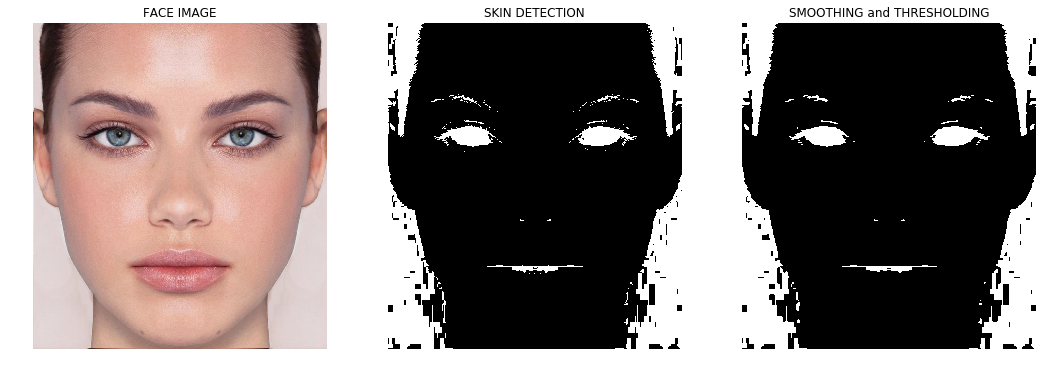

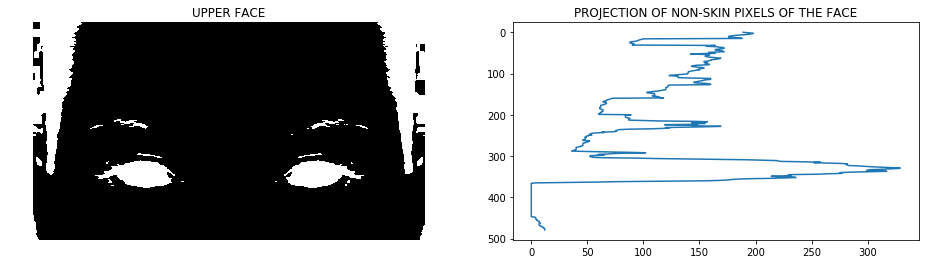

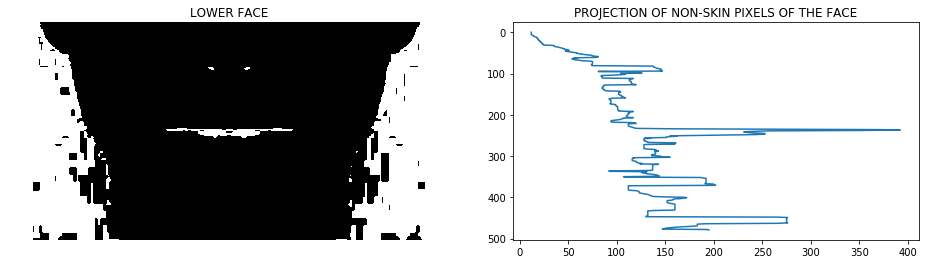

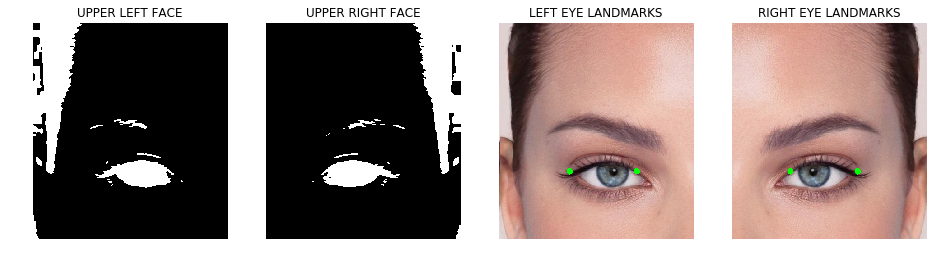

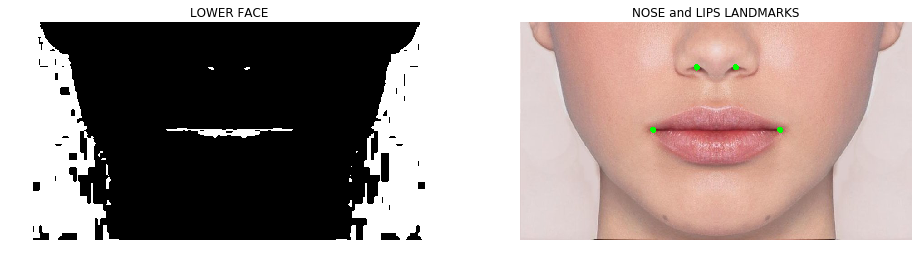

In [13]:
test = cv2.imread('images/test.jpg')
warnings.filterwarnings('ignore')
left_eye, right_eye, nose, lips = show_landmarks(test)


## 3. Morphing the Mask based on Facial Landmarks

In [30]:
def morph_mask_glasses(mask, face, left_eye_coordinates, right_eye_coordinates):

    # eye coordinates
    y1, x1 = left_eye_coordinates[0]
    y2, x2 = left_eye_coordinates[1]
    y3, x3 = right_eye_coordinates[0]
    y4, x4 = right_eye_coordinates[1]
        
    # eye center coordinates
    c1_x = int((x1+x2)/2)
    c1_y = int(y1)

    c2_x = int((x3+x4)/2)
    c2_y = int(y3)

    # top coordinates for glasses positioning
    top1_x = c1_x
    top1_y = int(y1-(x2-x1)/2)

    top2_x = c2_x
    top2_y = int(y3-(x4-x3)/2)

    # left coordinates for glasses positioning
    left1_x = int(x1-(0.35*(x2-x1)))
    left1_y = int(y1)

    # right coordinates for glasses positioning
    right2_x = int(x4+(0.35*(x4-x3)))
    right2_y = int(y4)
    
    # showing points on the face
    f = face.copy()
    cv2.circle(f, (int(x1),int(y1)), 5, (0, 255, 0))
    cv2.circle(f, (int(x2),int(y2)), 5, (0, 255, 0))
    cv2.circle(f, (int(x3),int(y3)), 5, (0, 255, 0))
    cv2.circle(f, (int(x4),int(y4)), 5, (0, 255, 0))

    cv2.circle(f, (int(c1_x),int(c1_y)), 5, (255, 0, 0))
    cv2.circle(f, (int(c2_x),int(c2_y)), 5, (255, 0, 0))

    cv2.circle(f, (int(top1_x),int(top1_y)), 5, (0, 0, 255))
    cv2.circle(f, (int(left1_x),int(left1_y)), 5, (0, 0, 255))

    cv2.circle(f, (int(right2_x),int(right2_y)), 5, (0, 0, 255))
    cv2.circle(f, (int(top2_x),int(top2_y)), 5, (0, 0, 255))
    cv2.imshow('Points on Face', f)
    cv2.waitKey(0)
    
    # convert transparent background of mask to white
    alpha = mask[:,:,3]
    b = mask[:,:,0]
    g = mask[:,:,1]
    r = mask[:,:,2]

    a = list(alpha.flatten())
    b = list(b.flatten())
    g = list(g.flatten())
    r = list(r.flatten())

    for i in range(len(b)):
        if a[i]==0:
            b[i]=255
            g[i]=255
            r[i]=255

    b = np.reshape(b, (mask.shape[0], mask.shape[1]))
    g = np.reshape(g, (mask.shape[0], mask.shape[1]))
    r = np.reshape(r, (mask.shape[0], mask.shape[1]))

    new_img = cv2.merge((b,g,r))

    cv2.imshow('Mask: Transparent to White Background', new_img.astype('uint8'))
    cv2.waitKey(0)

    cv2.imwrite('intermediate/glasses_white_background.jpg', new_img)
    
    new_mask = cv2.imread('intermediate/glasses_white_background.jpg')
    
    # fixed landmark positions for the glasses mask
    x1_mask = 65
    y1_mask = 85
    landmark1 = (x1_mask, y1_mask)

    x2_mask = 15
    y2_mask = 120
    landmark2 = (x2_mask, y2_mask)

    x3_mask = 255
    y3_mask = 120
    landmark3 = (x3_mask, y3_mask)

    x4_mask = 210
    y4_mask = 85
    landmark4 = (x4_mask, y4_mask)

    glasses_mask = new_mask.copy()
    cv2.circle(glasses_mask, landmark1, 5, (0, 0, 255))
    cv2.circle(glasses_mask, landmark2, 5, (0, 0, 255))
    cv2.circle(glasses_mask, landmark3, 5, (0, 0, 255))
    cv2.circle(glasses_mask, landmark4, 5, (0, 0, 255))
    cv2.imshow('Glasses Mask', glasses_mask)
    cv2.waitKey(0)
    
    # padding the mask image based on face image size
    (p, q) = face.shape[0:2]
    (m, n) = new_mask.shape[0:2]

    top = math.floor((p-m)/2)
    bottom = math.ceil((p-m)/2)

    left = math.floor((q-n)/2)
    right = math.ceil((q-n)/2)
    
    padded_mask = cv2.copyMakeBorder(new_mask, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    cv2.imshow('Padded Mask', padded_mask)
    cv2.waitKey(0)
    
    # now that the mask has been padded, the landmarks have to be adjusted accordingly
    landmark1_new = (landmark1[0]+left, landmark1[1]+top)
    landmark2_new = (landmark2[0]+left, landmark2[1]+top)
    landmark3_new = (landmark3[0]+left, landmark3[1]+top)
    landmark4_new = (landmark4[0]+left, landmark4[1]+top)

    padded_mask_landmarks = padded_mask.copy()
    cv2.circle(padded_mask_landmarks, landmark1_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark2_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark3_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark4_new, 5, (0, 0, 255))
    cv2.imshow('Updated Landmarks', padded_mask_landmarks)
    cv2.waitKey(0)
    
    # morphing the mask landmarks based on facial landmarks
    y1 = [landmark1_new[0], landmark2_new[0], landmark3_new[0], landmark4_new[0]]  # final mask landmarks x coordinates
    x1 = [landmark1_new[1], landmark2_new[1], landmark3_new[1], landmark4_new[1]]  # final mask landmarks y coordinates

    y2 = [top1_x, left1_x, right2_x, top2_x]  # face landmarks x coordinates
    x2 = [top1_y, left1_y, right2_y, top2_y]  # face landmarks y coordinates
    
    X1 = [[x1[0], y1[0], 1, 0, 0, 0], [0, 0, 0, x1[0], y1[0], 1]]
    X2 = [x2[0], y2[0]]

    for i in range(1, len(x1)):
        X1.append([x1[i], y1[i], 1, 0, 0, 0])
        X1.append([0, 0, 0, x1[i], y1[i], 1])
        X2.append(x2[i])
        X2.append(y2[i])

    p = np.linalg.lstsq(np.asarray(X1), np.asarray(X2).conj().transpose())[0]

    transformation_matrix = [[p[0], p[1], p[2]], [p[3], p[4], p[5]], [0, 0, 1]]
    
    # performing affine transformation of the mask using the transformation matrix computed above, with NN interpolation
    img2 = np.double(padded_mask)
    img2 = img2[:,:,0]
    
    new_img = np.zeros((img2.shape[0], img2.shape[1]))
    new_img = new_img + 255  # making it white
    
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            current_pixel = [[i], [j], [1]]
            new_pixel = np.linalg.lstsq(np.asarray(transformation_matrix), np.asarray(current_pixel))[0].tolist()

            new_x = new_pixel[0][0]
            new_y = new_pixel[1][0]

            if (new_x>=0 and new_y>=0 and new_x<img2.shape[0] and new_y<img2.shape[1]):
                nn_x = round(new_x)
                nn_y = round(new_y)

                if nn_x >= img2.shape[0]:
                    nn_x = img2.shape[0]-1

                if nn_y >= img2.shape[1]:
                    nn_y = img2.shape[1]-1

                intensity = img2[nn_x][nn_y]
                new_img[i][j] = intensity
                
    cv2.imshow('Morphed Mask', new_img.astype('uint8'))
    cv2.waitKey(0)
    imsave('morphed_masks/glasses.jpg', new_img.astype('uint8'))

In [43]:
# takes a transparent mask, face image and nose, lips landmark coordinates and morphs the mask based on the coordinates
# saves morphed mask as a jpg file

def morph_mask_moustache(mask, face, lips_coordinates, nose_coordinates):
    
    # lips and nose coordinates
    y1_face, x1_face = lips_coordinates[0]
    y2_face, x2_face = nose_coordinates[0]
    y3_face, x3_face = nose_coordinates[1]
    y4_face, x4_face = lips_coordinates[1]

    # showing points on the face
    f = face.copy()
    cv2.circle(f, (int(x1_face),int(y1_face)), 5, (0, 255, 0))
    cv2.circle(f, (int(x2_face),int(y2_face)), 5, (0, 255, 0))
    cv2.circle(f, (int(x3_face),int(y3_face)), 5, (0, 255, 0))
    cv2.circle(f, (int(x4_face),int(y4_face)), 5, (0, 255, 0))

    cv2.imshow('Points on Face', f)
    cv2.waitKey(0)
    
    # convert transparent background of mask to white
    alpha = mask[:,:,3]
    b = mask[:,:,0]
    g = mask[:,:,1]
    r = mask[:,:,2]

    a = list(alpha.flatten())
    b = list(b.flatten())
    g = list(g.flatten())
    r = list(r.flatten())

    for i in range(len(b)):
        if a[i]==0:
            b[i]=255
            g[i]=255
            r[i]=255

    b = np.reshape(b, (mask.shape[0], mask.shape[1]))
    g = np.reshape(g, (mask.shape[0], mask.shape[1]))
    r = np.reshape(r, (mask.shape[0], mask.shape[1]))

    new_img = cv2.merge((b,g,r))

    cv2.imshow('Mask: Transparent to White Background', new_img.astype('uint8'))
    cv2.waitKey(0)

    cv2.imwrite('intermediate/moustache_white_background.jpg', new_img)
    
    new_mask = cv2.imread('intermediate/moustache_white_background.jpg')
    
    # fixed landmark positions for the moustache mask
    x1_mask = 45
    y1_mask = 125
    landmark1 = (x1_mask, y1_mask)

    x2_mask = 140
    y2_mask = 40
    landmark2 = (x2_mask, y2_mask)

    x3_mask = 180
    y3_mask = 40
    landmark3 = (x3_mask, y3_mask)

    x4_mask = 270
    y4_mask = 125
    landmark4 = (x4_mask, y4_mask)

    moustache_mask = new_mask.copy()
    cv2.circle(moustache_mask, landmark1, 5, (0, 0, 255))
    cv2.circle(moustache_mask, landmark2, 5, (0, 0, 255))
    cv2.circle(moustache_mask, landmark3, 5, (0, 0, 255))
    cv2.circle(moustache_mask, landmark4, 5, (0, 0, 255))
    cv2.imshow('moustache Mask', moustache_mask)
    cv2.waitKey(0)
    
    # padding the mask image based on face image size
    (p, q) = face.shape[0:2]
    (m, n) = new_mask.shape[0:2]

    top = math.floor((p-m)/2)
    bottom = math.ceil((p-m)/2)

    left = math.floor((q-n)/2)
    right = math.ceil((q-n)/2)
    
    padded_mask = cv2.copyMakeBorder(new_mask, top, bottom, left, right, cv2.BORDER_REPLICATE)
    
    cv2.imshow('Padded Mask', padded_mask)
    cv2.waitKey(0)
    
    # now that the mask has been padded, the landmarks have to be adjusted accordingly
    landmark1_new = (landmark1[0]+left, landmark1[1]+top)
    landmark2_new = (landmark2[0]+left, landmark2[1]+top)
    landmark3_new = (landmark3[0]+left, landmark3[1]+top)
    landmark4_new = (landmark4[0]+left, landmark4[1]+top)

    padded_mask_landmarks = padded_mask.copy()
    cv2.circle(padded_mask_landmarks, landmark1_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark2_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark3_new, 5, (0, 0, 255))
    cv2.circle(padded_mask_landmarks, landmark4_new, 5, (0, 0, 255))
    cv2.imshow('Updated Landmarks', padded_mask_landmarks)
    cv2.waitKey(0)
    
    # morphing the mask landmarks based on facial landmarks
    y1 = [landmark1_new[0], landmark2_new[0], landmark3_new[0], landmark4_new[0]]  # final mask landmarks x coordinates
    x1 = [landmark1_new[1], landmark2_new[1], landmark3_new[1], landmark4_new[1]]  # final mask landmarks y coordinates

    y2 = [x1_face, x2_face, x3_face, x4_face]  # face landmarks x coordinates
    x2 = [y1_face, y2_face, y3_face, y4_face]  # face landmarks y coordinates

    X1 = [[x1[0], y1[0], 1, 0, 0, 0], [0, 0, 0, x1[0], y1[0], 1]]
    X2 = [x2[0], y2[0]]

    for i in range(1, len(x1)):
        X1.append([x1[i], y1[i], 1, 0, 0, 0])
        X1.append([0, 0, 0, x1[i], y1[i], 1])
        X2.append(x2[i])
        X2.append(y2[i])


    p = np.linalg.lstsq(np.asarray(X1), np.asarray(X2).conj().transpose())[0]

    transformation_matrix = [[p[0], p[1], p[2]], [p[3], p[4], p[5]], [0, 0, 1]]
    
    # performing affine transformation of the mask using the transformation matrix computed above, with NN interpolation
    img2 = np.double(padded_mask)
    img2 = img2[:,:,0]
    
    new_img = np.zeros((img2.shape[0], img2.shape[1]))
    new_img = new_img + 255  # making it white
    
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            current_pixel = [[i], [j], [1]]
            new_pixel = np.linalg.lstsq(np.asarray(transformation_matrix), np.asarray(current_pixel))[0].tolist()

            new_x = new_pixel[0][0]
            new_y = new_pixel[1][0]

            if (new_x>=0 and new_y>=0 and new_x<img2.shape[0] and new_y<img2.shape[1]):
                nn_x = round(new_x)
                nn_y = round(new_y)

                if nn_x >= img2.shape[0]:
                    nn_x = img2.shape[0]-1

                if nn_y >= img2.shape[1]:
                    nn_y = img2.shape[1]-1

                intensity = img2[nn_x][nn_y]
                new_img[i][j] = intensity
                
    cv2.imshow('Morphed Mask', new_img.astype('uint8'))
    cv2.waitKey(0)
    imsave('morphed_masks/foreground.jpg', new_img.astype('uint8'))


## 4. Overlaying the Mask onto the Face

In [36]:
def alpha_blending(background_path, resized_mask_path):
    
    # Fetching the resized foreground mask
    resized_foreground = Image.open(resized_mask_path)
    
    # Getting the RGBA tuple of each pixel in the foreground
    data = resized_foreground.getdata()
    
    newData = []
    
    # Alpha Blending
    for item in data:
        if item[0] > 100 and item[1] > 100 and item[2] > 100:
            newData.append((0,0,0,0))
        else:
            newData.append(item)
    
    resized_foreground.putdata(newData)
    resized_foreground.save('morphed_masks/final_foreground.png', format='png')
    
    mask = Image.open('morphed_masks/final_foreground.png').convert('RGBA')
    background = Image.open(background_path).convert('RGBA')
    
    background.paste(mask,None,mask)
    background.show()
    background.save('output/final_overlay.png', format='png')

In [32]:
def image_resize(background_path, foreground_path):
    
    # Reading Images using the PIL library
    # Converting the read image to RGBA format to obtain the alpha value
    background = Image.open(background_path).convert('RGBA')
    foreground = Image.open(foreground_path).convert('RGBA')
    
    # Determining the size of the background image
    b_width, b_height = background.size
    
    # Resizing the foreground image in accordance with the background
    foreground_resized = foreground.resize((b_width, b_height), Image.LANCZOS)
    
    # Saving the new resized foreground image
    # Format chosen is png, to make sure that the Alpha channel is intact
    foreground_resized.save('morphed_masks/newforeground.png', format='png')
    
    resized_mask_path = 'morphed_masks/newforeground.png'
    
    alpha_blending(background_path, resized_mask_path)

## 5. Working demo for glasses

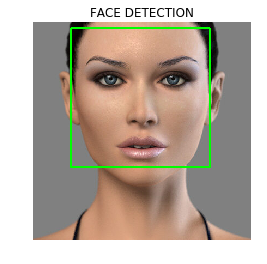

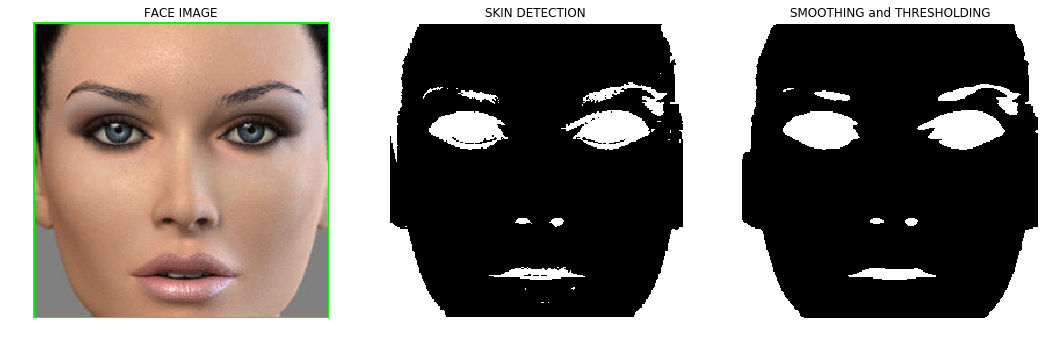

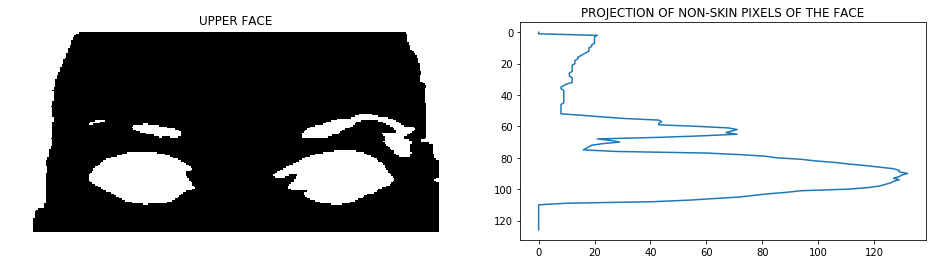

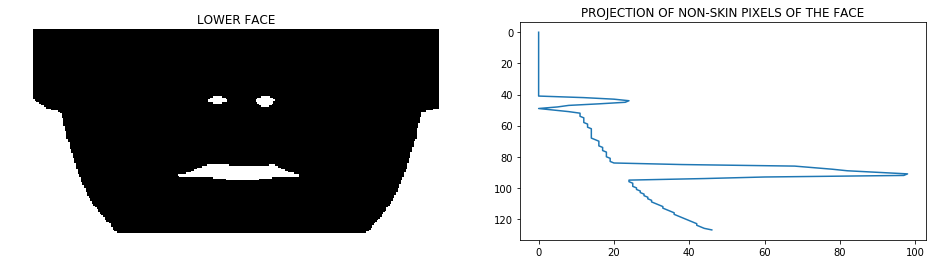

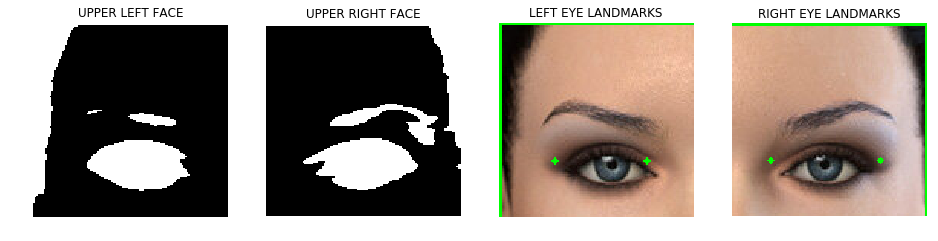

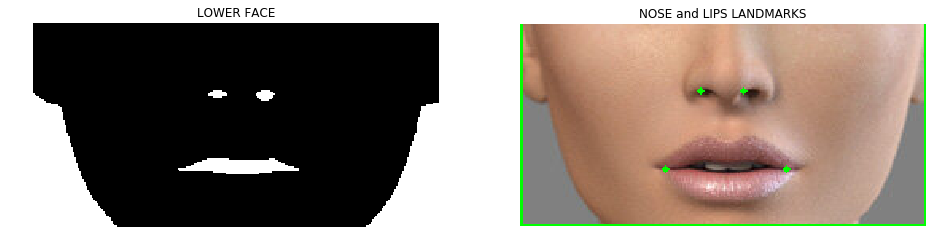

In [37]:
image_path = 'images/face-woman.jpg'
mask_path = 'original_masks/glasses.png'

input_image = cv2.imread(image_path)
face_image = input_image.copy()

coordinates, face_image = face_detection(input_image)

landmarks = show_landmarks(face_image)

for i in range(len(landmarks)):
    landmarks[i][0][0] += coordinates[1]  # start_x
    landmarks[i][0][1] += coordinates[0]  # start_y
    landmarks[i][1][0] += coordinates[1]  # end_x
    landmarks[i][1][1] += coordinates[0]  # end_y

mask_glass = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
input_image = cv2.imread(image_path)

morph_mask_glasses(mask_glass, input_image, landmarks[0], landmarks[1])

morphed_mask_path = 'morphed_masks/glasses.jpg'
image_resize(image_path, morphed_mask_path)

warnings.filterwarnings('ignore')


The morphed mask and the overlayed image is being saved to local directory and pops up while running the code (cv2.imshow()). Reading the output images to store in notebook.

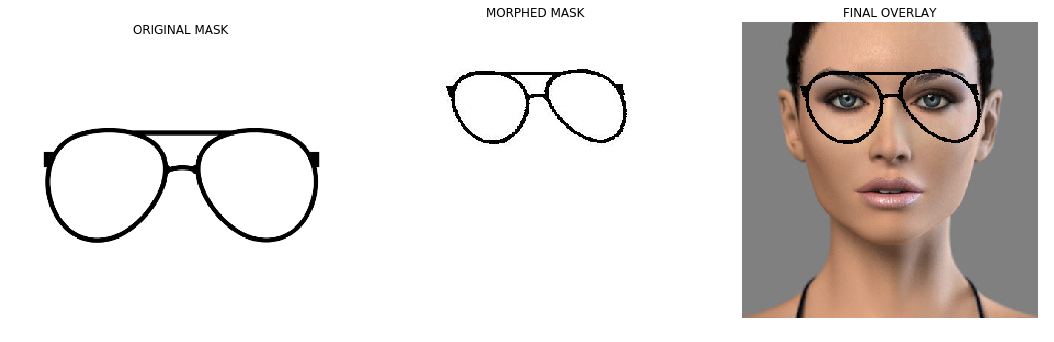

In [41]:
mask_glass = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
mask_glass_morphed = cv2.imread(morphed_mask_path, cv2.IMREAD_UNCHANGED)
final_output = cv2.imread('output/final_overlay.png')

fig = plt.figure(figsize=(18,6))
fig.add_subplot(1,3,1)
disp_image(mask_glass, 'ORIGINAL MASK', gray=True)
fig.add_subplot(1,3,2)
disp_image(mask_glass_morphed, 'MORPHED MASK', gray=True)
fig.add_subplot(1,3,3)
disp_image(final_output, 'FINAL OVERLAY', gray=False)
plt.show()


## 5. Working demo for moustache

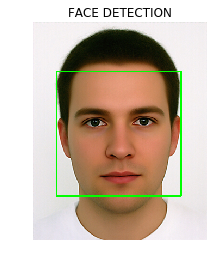

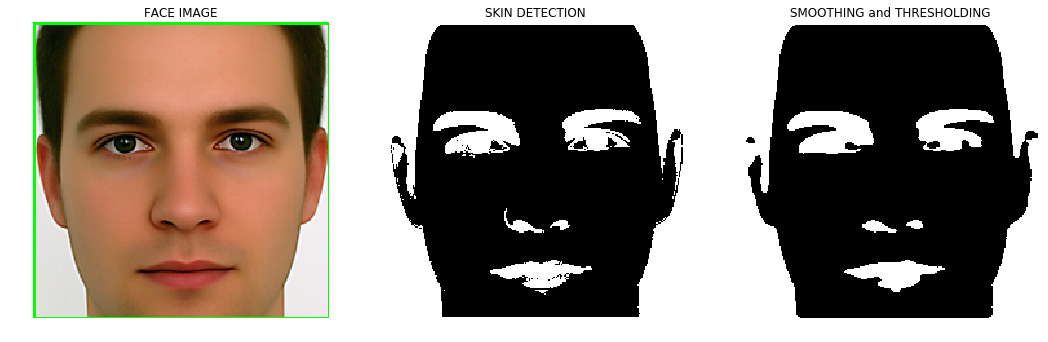

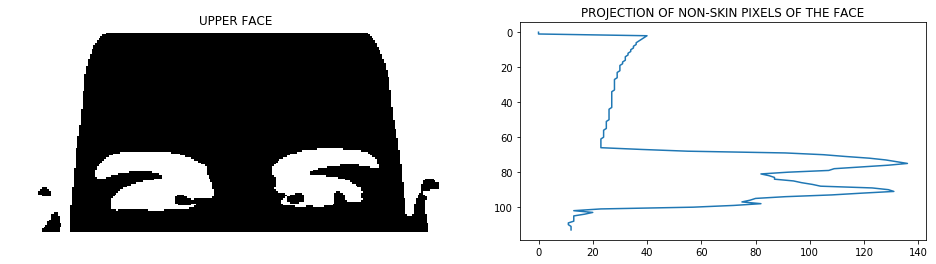

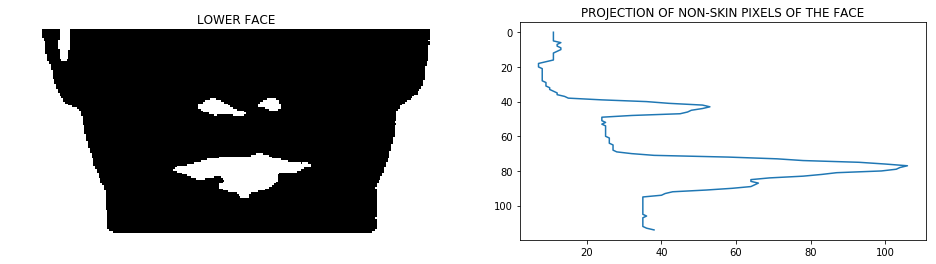

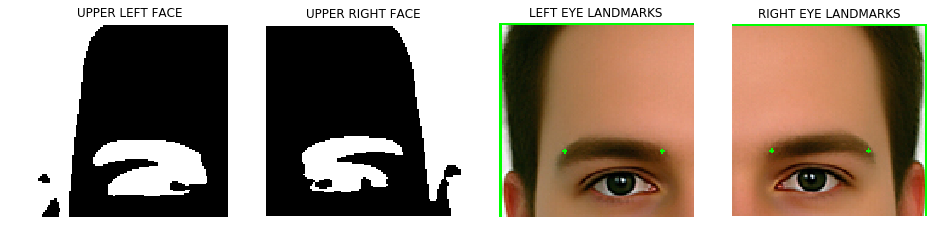

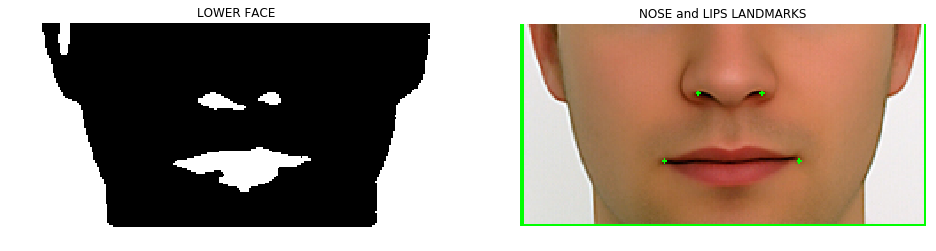

In [48]:
image_path = 'images/face_man.jpg'
mask_path = 'original_masks/moustache.png'

input_image = cv2.imread(image_path)
face_image = input_image.copy()

coordinates, face_image = face_detection(input_image)

landmarks = show_landmarks(face_image)

for i in range(len(landmarks)):
    landmarks[i][0][0] += coordinates[1]  # start_x
    landmarks[i][0][1] += coordinates[0]  # start_y
    landmarks[i][1][0] += coordinates[1]  # end_x
    landmarks[i][1][1] += coordinates[0]  # end_y

mask_glass = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
input_image = cv2.imread(image_path)

morph_mask_moustache(mask_glass, input_image, landmarks[3], landmarks[2])

morphed_mask_path = 'morphed_masks/foreground.jpg'
image_resize(image_path, morphed_mask_path)

warnings.filterwarnings('ignore')


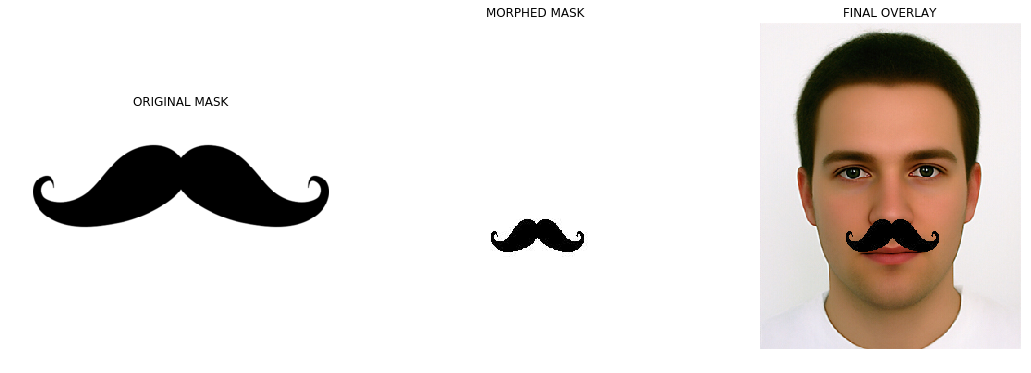

In [49]:
mask_glass = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
mask_glass_morphed = cv2.imread(morphed_mask_path, cv2.IMREAD_UNCHANGED)
final_output = cv2.imread('output/final_overlay.png')

fig = plt.figure(figsize=(18,6))
fig.add_subplot(1,3,1)
disp_image(mask_glass, 'ORIGINAL MASK', gray=True)
fig.add_subplot(1,3,2)
disp_image(mask_glass_morphed, 'MORPHED MASK', gray=True)
fig.add_subplot(1,3,3)
disp_image(final_output, 'FINAL OVERLAY', gray=False)
plt.show()

The morphed mask and the overlayed image is being saved to local directory and pops up while running the code (cv2.imshow()). Reading the output images to store in notebook.